In [1]:
from common import tasks
import pandas as pd

my = tasks()
dir = my.dir

to_date = pd.to_datetime("2024-06-01")
from_date = to_date - pd.Timedelta(14, "d")

main_df = my.get_news(from_date, to_date)
imoex_df = my.get_imoex(from_date, to_date)
quotes_df = my.get_quotes(from_date, to_date)
shares_pd = my.moex_cb()
quotes_df

In [33]:
import plotly.express as px
# This dataframe has 244 lines, but 4 distinct values for `day`
df = main_df.groupby([pd.Grouper(key='CHANNEL')]).agg('count')
df.reset_index(inplace=True)
df
fig = px.pie(df, values='NEWS_TEXT', names='CHANNEL',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='value+label', showlegend = False)
fig.show()

In [4]:
import plotly.express as px
for ticker in my.tickers_list:
    temp_df = quotes_df[quotes_df["SECID"]==ticker]
    fig = px.line(temp_df, x="TRADEDATE", y="WAPRICE", title=ticker)
    fig.show()
    # print(len(temp_df))



In [92]:
import plotly.express as px

data = dict(
    number=[len(main_df), 
            main_df[(main_df["TICKERS"].str.len()>2)]["TICKERS"].count(), 
            main_df[(main_df["TICKERS"].str.len()>2) & (main_df["TICKERS"].str.len()<5)]["TICKERS"].count()],
    stage=["Всего постов", "С тикерами", "С одним тикером"])
fig = px.funnel(data, x='number', y='stage')

fig.show()

In [53]:
quotes_df.sort_values(by="TRADEDATE", ascending=True, inplace=True)
# tickers_list = my.tickers_list
tickers_list = pd.unique(quotes_df["SECID"])
limit = 0.1 # отклонение цены от скользящего среднего (%/100). При 0 отображаются все
stat_df = my.quotes_stat(tickers_list, quotes_df)
# отбор среди списка моих акций с отклонением выше порогового
stat_df = stat_df[(stat_df["DEV"]>=limit) | (stat_df["DEV"]<=-limit)]
stat_group = stat_df.groupby(by = ["SECID"])[["SECID"]].count().rename_axis(["TICKER"])
stat_group.reset_index(inplace=True)
stat_group = pd.merge(
    stat_group, shares_pd, left_on=["TICKER"], right_on=["TRADE_CODE"], how="left"
)
stat_group.drop("TRADE_CODE", axis = 1, inplace=True)
stat_group.rename(columns = {'SECID':'count'}, inplace = True )
stat_group

import plotly.express as px
fig = px.treemap(stat_group,
                 path=['TICKER'],
                 values='count',
                 labels="count",
                 color="count",
                 color_continuous_scale='RdYlGn_r'
                 )
fig.update_layout(title="Отклонения от средневзвешенной цены на "+str(limit*100)+"%",
                #   width=1000,
                #   height=700,
                  font_size = 14)

fig.show()

In [26]:
from textblob import TextBlob
ticker_df = main_df.loc[main_df["TICKERS"].isin(my.tickers_list), : ]

# сентимент анализ
def mood_text(text):
    # Используем TextBlob для анализа тональности
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity
    if sentiment > 0:
        sentiment_label = "positive"
    elif sentiment < 0:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"

    return sentiment_label

ticker_df["Mood"] = ticker_df["WORDS_lemma"].apply(lambda x: mood_text(x))
df = ticker_df[["NEWS_DATE", "TICKERS", "NEWS_TEXT", "Mood"]].sort_values(["NEWS_DATE"], ascending=False)

# map_color = {"positive":"green", "negative":"red", "neutral":"grey"}

import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                align='left'),
    cells=dict(values=[df["NEWS_DATE"].dt.strftime("%d-%m-%Y"), df.TICKERS,  df.NEWS_TEXT, df.Mood],
               align='left'
               ),
    columnorder = [1,2,3,4],
    columnwidth = [70,50,400,40]
    )
])
fig.update_layout(width=1000,
                  height=2000)

fig.show()

C:\Users\user\AppData\Local\Temp\ipykernel_3880\2200817591.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
import networkx as nx
from itertools import combinations

# суммаризация текста
def similarity(s1, s2):
    if not len(s1) or not len(s2):
        return 0.0
    return len(s1.intersection(s2))/(1.0 * (len(s1) + len(s2)))
# Выдает список предложений отсортированных по значимости
def textrank(text):
    sentences = sent_tokenize(text)
    tokenizer = RegexpTokenizer(r'\w+')
    lmtzr = RussianStemmer()
    words = [set(lmtzr.stem(word) for word in tokenizer.tokenize(sentence.lower()))
             for sentence in sentences] 	 
    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(words[i], words[j])) for i, j in pairs]
    scores = filter(lambda x: x[2], scores)
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pr = nx.pagerank(g)
    return sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr), key=lambda x: pr[x[0]], reverse=True)
# Сокращает текст до нескольких наиболее важных предложений
def sumextract(text, n=5):
    tr = textrank(text)
    top_n = sorted(tr[:n])
    return ' '.join(x[2] for x in top_n)

group_news = main_df.groupby('NEWS_DATE', group_keys=True)[["NEWS_TEXT"]].agg(lambda x: ','.join(x))
group_news["Summary"] = group_news["NEWS_TEXT"].apply(sumextract)
group_news = group_news.drop("NEWS_TEXT", axis=1)
group_news.reset_index(inplace=True)
group_news["NEWS_DATE"] = pd.to_datetime(group_news["NEWS_DATE"]).dt.strftime("%d-%m-%Y")
df = group_news[["NEWS_DATE", "Summary"]].sort_values(["NEWS_DATE"], ascending=False)


import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                align='left'),
    cells=dict(values=[df.NEWS_DATE, df.Summary],
               align='left'
               ),
    columnorder = [1,2],
    columnwidth = [70,400]
    )
])
fig.update_layout(width=1000,
                  height=2000)

fig.show()


In [61]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

groupNews = main_df.groupby("NEWS_DATE").size().to_frame(name = 'count').reset_index()
fig = make_subplots(specs=[[{"secondary_y": True}]])
# задаем отображение количества новостей
fig.add_trace(
    go.Bar(
        name = "Количество постов",
        x=groupNews["NEWS_DATE"], y=groupNews["count"],
        marker=dict(color="lightsteelblue"),
        opacity=0.5,
    ),
    secondary_y=True
)
# задаем отображение динамики индекса
fig.add_trace(
    go.Candlestick(
        name = "Цена IMOEX",
        x=imoex_df['Date'],
        open=imoex_df['Open'],
        high=imoex_df['High'],
        low=imoex_df['Low'],
        close=imoex_df['Open']+(imoex_df['Open']/100*imoex_df['Change']),
    ),
    secondary_y=False
)
# добавляем заголовок
# fig.update_layout(title = 'Динамика <b>IMOEX</b>', xaxis_rangeslider_visible=False)
fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()


(-0.5, 2999.5, 1999.5, -0.5)

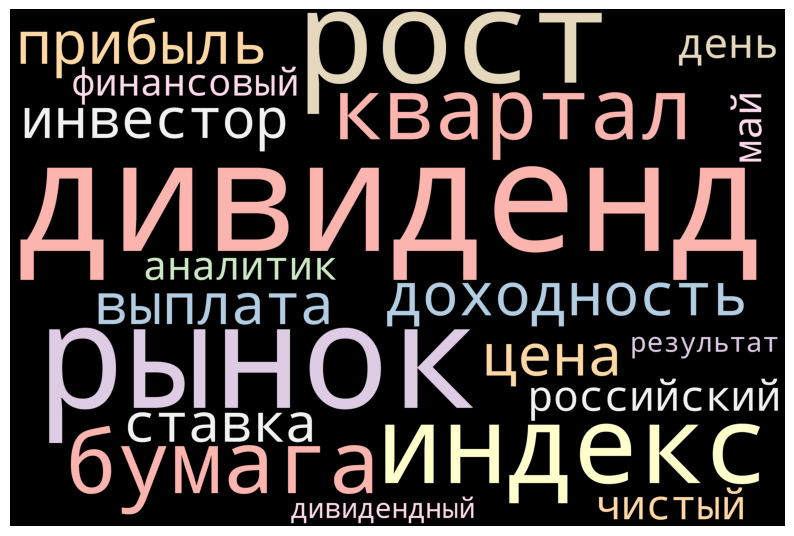

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_forBOW = main_df["WORDS_lemma"].values.astype(str)

plt.figure(figsize=(10, 10))
plt.imshow(WordCloud(width = 3000, 
                    height = 2000,
                    max_words = 20,
                    stopwords = ["компания", "акция", "идея", "наш"], 
                    random_state=1, 
                    background_color='black', 
                    margin=20, 
                    colormap='Pastel1', 
                    collocations=False).generate(" ".join(text_forBOW))) 
plt.axis("off")


In [ ]:
main_df = my.get_news("2024-05-01", "2024-05-20")
main_df

text = my.dflist_to_text(main_df["WORDS_lemma"])
len(text)

In [ ]:
# фрейм с новостями в интервале дат
main_df = my.news_df

def get_news(from_date, to_date):
    return main_df[
        (main_df["NEWS_DATE"] >= pd.to_datetime(from_date)) &
        (main_df["NEWS_DATE"] <= pd.to_datetime(to_date))
        ][
            ["CHANNEL", "NEWS_DATE", "NEWS_TEXT", "TICKERS", "WORDS", "WORDS_lemma"]
            ].sort_values(by="NEWS_DATE", ascending=False)

to_date = max(main_df["NEWS_DATE"])
from_date = to_date - pd.Timedelta(14, "d")

In [ ]:
imoex = my.imoex_df()
imoex

In [ ]:
import pandas as pd
main_df = pd.read_csv(dir + "Answers\\news_quotes.csv", encoding="utf-8", sep="|")
main_df.head()                                  

In [ ]:
tickers_list = my.tickers_list

from_date = "2024-01-01"
to_date = "2024-03-30"
ticker = "sber"

def get_news(from_date, to_date, ticker):
    if ticker=="imoex":
        ticker == ""
    return main_df[(main_df["TICKERS"]==ticker)][["CHANNEL", "NEWS_DATE", "NEWS_TEXT", "TICKERS"]]

# print(len(df[(df["NEWS_DATE"] < to_date) & (df["NEWS_DATE"] >= from_date)]))

temp_df = pd.DataFrame()
for ticker in tickers_list:
    temp_df = pd.concat([temp_df, get_news(from_date, to_date, ticker)])

# group_news = temp_df.groupby("NEWS_DATE", group_keys=True)[["NEWS_TEXT"]].apply(lambda x: x)
group_news = temp_df.groupby('NEWS_DATE', group_keys=True)[["NEWS_TEXT"]].agg(lambda x: ','.join(x))



from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
import networkx as nx
from itertools import combinations

def similarity(s1, s2):
    if not len(s1) or not len(s2):
        return 0.0
    return len(s1.intersection(s2))/(1.0 * (len(s1) + len(s2)))

# Выдает список предложений отсортированных по значимости
def textrank(text):
    sentences = sent_tokenize(text)
    tokenizer = RegexpTokenizer(r'\w+')
    lmtzr = RussianStemmer()
    words = [set(lmtzr.stem(word) for word in tokenizer.tokenize(sentence.lower()))
             for sentence in sentences] 	 
    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(words[i], words[j])) for i, j in pairs]
    scores = filter(lambda x: x[2], scores)
    g = nx.Graph()
    g.add_weighted_edges_from(scores)
    pr = nx.pagerank(g)
    return sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr), key=lambda x: pr[x[0]], reverse=True)

# Сокращает текст до нескольких наиболее важных предложений
def sumextract(text, n=5):
    tr = textrank(text)
    top_n = sorted(tr[:n])
    return ' '.join(x[2] for x in top_n)


group_news["Summary_2"] = group_news["NEWS_TEXT"].apply(sumextract)
group_news["date"] = group_news.index

group_news


In [ ]:
from wordcloud import WordCloud # Generate wordclouds
import matplotlib.pyplot as plt

# import ast
# Функция для визуализации облака слов
def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(10, 10))
    # Показать изображение
    plt.imshow(wordcloud) 
    # Без подписей на осях
    plt.axis("off")

text = main_df["WORDS_lemma"].astype(str)
text = text.str.replace("[","")
text = text.str.replace("]","")
text = text.str.replace(",","")
text = text.str.replace("'","")

# Генерируем облако слов
wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=1, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False).generate(text.to_string())


# Рисуем картинку
plot_cloud(wordcloud)

